# CSCI 381 - Deep Learning (Spring 2025) - Project 2

**Due Date: Friday, March 14 by 11:59 PM ET**

## Description
In this assignment you will develop a neural network with fully-connected layers to perform classification using a toy dataset, after which you will train and evaluate a neural network classifier for the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

## Instructions
**Please follow the instructions in Project 1A regarding how to add code to this project's notebook and associated Python files.**
1. In this assignment you will write code to construct machine learning models and write responses to questions concerning the performance of said models. Please complete all sections below, adding new *Code* or *Markdown* cells as appropriate to answer the questions.
2. You will **only** utilize elementary functions in `Pytorch` to implement your neural network, e.g.,
    * *Matrix/Tensor Operations* such as `sum`, `mm`, `exp`, `log`, and `transpose`; and 
    * `clamp` - for implementing ReLU.

## Running Code
You will use the programming environment (Google Colab, Kaggle, or Local) that you configured in Project 0. The project is configured to use hardware acceleration when available. Instructions for Google Colab are included in the "Google Colab Setup" section.

## Expectations
You will **work independently** on the assignment. Please make use of the *Python/Pytorch/Data Science Reference Materials* posted on Brightspace, or **come to office hours should you need further assistance**.

## Submission Instructions
You will submit to Brightspace by the due date listed above:
   * Your completed Jupyter notebook and `two_layer_net.py` files.
   * Your computation graph image (Part 1.1)
   * Your saved best model `nn_best_model.pt` for the CIFAR-10 dataset (Part 2.2)

## Grading Rubric
|**Part**|1.1|1.2|1.3|1.4|1.5|2.1|2.2|**Total**|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|**%**|15|5|10|30|10|20|10|100|

<sub><sup>Modified by J. Gryak, Spring 2025. *Original Author*: [Justin C. Johnson](https://web.eecs.umich.edu/~justincj/)</sup></sub>

# Part 0: Assignment Setup

# Setup Code (All Environments)
Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

## Setup Jupyter Environment and Import Libraries

In [2]:
import utils
import torch
import matplotlib.pyplot as plt
import random
import time
%matplotlib inline


plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

RANDOM_STATE=0

## Device/Precision Selection
[Pytorch](https://pytorch.org/) and other libraries ([Tensorflow](https://www.tensorflow.org/), [JAX](https://docs.jax.dev/en/latest/)) enable computations to be performed on GPUs. In order for your code to take advantage of this hardware the various matrices/tensors must either be created on those GPUs or copied to them. The libraries for this project have been designed so that you can specify the device to use globally and the various routines will take care of this technicality for you. **However, if you create any temporary tensors in your code, you must specify the device manually.**

You can use the conditional statement below to select the appropriate hardware for the project. Alternatively, you can simply hardcode your choice in the `device` variable. **Note that MPS devices only support 32-bit (single) precision.**

In [3]:
# Get cpu, gpu or mps device for training.

#if you have a CUDA-enabled nVidia GPU on your system, or are using Google Colab
if torch.cuda.is_available():
    device="cuda"
    dtype=torch.float64
#if you have a Mac with an M1 or greater processor and macOS 13 or greater
elif torch.backends.mps.is_available():
    device="mps"
    dtype=torch.float32
#otherwise use the system's CPU
else:
    device="cpu"
    dtype=torch.float64

print(f"Using {device} device")

Using cpu device


### Google Colab Setup (Skip for Kaggle and Local Enviroments)
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the following cell should print the filenames from the assignment:

```
['two_layer_net.py', 'Project 2 - Two-Layer NN - Student Version.ipynb', 'utils.py']
```

In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2025SP folder and put all the files under Project2 folder, then '2025SP/Project2'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2025SP/Project2'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from two_layer_net.py!
Hello from utils.py!
```

as well as the last edit time for the file `two_layer_net.py`.

In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from two_layer_net import hello_two_layer_net
hello_two_layer_net()

from utils import hello_helper
hello_helper()

two_layer_net_path = os.path.join(GOOGLE_DRIVE_PATH, 'two_layer_net.py')
two_layer_net_edit_time = time.ctime(os.path.getmtime(two_layer_net_path))
print('two_layer_net.py last edited on %s' % two_layer_net_edit_time)

# Part 1: Implement a Two-Layer Neural Network Using a Toy Dataset
You will implement a **two-layer neural network**  for *multiclass* classification with a **softmax output**. The network will be optmized using **cross-entropy loss** and **$\ell_2$ regularization** on the weight matrices. The network will use a **ReLU** activation function after the first fully connected layer. 

In other words, the network has the following architecture:

> **Input** -> **Fully Connected Layer** -> **ReLU** -> **Fully Connected Layer** -> **Softmax**

The outputs of the second fully-connected layer are the *scores* for each class, which are turned into *probabilities* by the softmax function.

You will implement this two-layer network in **stages** in the Python file `two_layer_net.py`. 

## The Toy Dataset

The inputs to the network will be a batch of $N$ (`num_inputs`) $D$-dimensional vectors (`input_size`); the hidden layer will have $H$ hidden units (`hidden_size`), and the output will be classification scores for $C$ categories (`num_classes`). This means that the learnable weights and biases of the network will have the following shapes:

*   $W_1$: First layer weights; has shape $(D, H)$
*   $b_1$: First layer biases; has shape $(H,)$
*   $W_2$: Second layer weights; has shape $(H, C)$
*   $b_2$: Second layer biases; has shape $(C,)$

The function `utils.get_toy_data` will generate random weights for this small toy dataset to help with model implementation.

## 1.1 - Create a Computation Graph
As shown in *Lecture 5 (slide 16)*, create a **computation graph** that depicts the *variables*, *functions*, and their *input/output* relationship.

You may draw your graph by hand and scan it or use software to generate it, e.g., Microsoft Visio, [Draw.io](https://app.diagrams.net/). In either case, upload the picture with your submission and insert it into a cell below using Markdown.

![Alt text](p2_computational_graph.jpg)

## 1.2 - Forward Pass: Compute Scores
Implement the forward pass of the network, which uses the weights and biases to compute scores for all inputs, in the function `nn_forward_pass` located in the Python file `two_layer_net.py`. 

Use the code below to compute the scores and compare with the answer. The total (sum) absolute difference should be smaller than `1e-5`.

In [13]:
from utils import get_toy_data
from two_layer_net import nn_forward_pass

utils.reset_seed(RANDOM_STATE)
toy_X, toy_y, params = get_toy_data(dtype=dtype,device=device)
# TODO: Implement the score computation part of nn_forward_pass
scores, _ = nn_forward_pass(params, toy_X)
print('Your scores:')
print(scores)
print(scores.dtype)
print()
print('correct scores:')
correct_scores = torch.tensor([
        [ 9.7003e-08, -1.1143e-07, -3.9961e-08],
        [-7.4297e-08,  1.1502e-07,  1.5685e-07],
        [-2.5860e-07,  2.2765e-07,  3.2453e-07],
        [-4.7257e-07,  9.0935e-07,  4.0368e-07],
        [-1.8395e-07,  7.9303e-08,  6.0360e-07]], dtype=torch.float64, device=scores.device)
print(correct_scores)
print()

# The difference should be very small. We get < 1e-5
p12_scores_diff = (scores - correct_scores).abs().sum().item()
print('Difference between your scores and correct scores: %.2e' % p12_scores_diff)

Your scores:
tensor([[ 1.1693e-07, -1.9933e-07,  1.2776e-07],
        [ 1.1282e-07,  4.1267e-07,  1.7140e-07],
        [ 1.6932e-07,  4.4674e-07, -4.9214e-08],
        [ 6.4343e-07,  6.1633e-07, -3.6899e-07],
        [ 4.6809e-08,  3.3397e-07, -5.8308e-09]], dtype=torch.float64)
torch.float64

correct scores:
tensor([[ 9.7003e-08, -1.1143e-07, -3.9961e-08],
        [-7.4297e-08,  1.1502e-07,  1.5685e-07],
        [-2.5860e-07,  2.2765e-07,  3.2453e-07],
        [-4.7257e-07,  9.0935e-07,  4.0368e-07],
        [-1.8395e-07,  7.9303e-08,  6.0360e-07]], dtype=torch.float64)

Difference between your scores and correct scores: 5.07e-06


## 1.3 Forward Pass: Compute Loss
Now implement the first part of `nn_forward_backward` that computes the data and regularization loss.

For the data loss, use **cross-entropy loss**. For the regularization loss, use  **$\ell_2$ regularization** on the weight matrices $W_1$ and $W_2$; no regularization loss is applied to the bias vectors  $b_1$ and $b_2$.

The code below will compute the loss on the toy data, and compare your answer to that computed by the reference implementation. The difference between the correct and computed loss should be less than `1e-4`.

### Please Read!
* You may find the writeup on softmax and cross-entropy loss in Chapter 4 of [*Dive into Deep Learning*](https://d2l.ai/d2l-en.pdf) helpful in implementing these functions.
* When you implement the regularization over the $W$s, **please DO NOT multiply the regularization term by 1/2**.

In [14]:
import utils
from utils import get_toy_data
from two_layer_net import nn_forward_backward

utils.reset_seed(RANDOM_STATE)
toy_X, toy_y, params = get_toy_data(dtype=dtype,device=device)

# YOUR_TURN: Implement the loss computation part of nn_forward_backward
loss, _ = nn_forward_backward(params, toy_X, toy_y, reg=0.05)
print('Your loss: ', loss.item())
correct_loss = 1.0986121892929077
print('Correct loss: ', correct_loss)
p13_diff = (correct_loss - loss).item()

# should be very small, we get < 1e-4
print('Difference: %.4e' % p13_diff)

Your loss:  1.0986124016899326
Correct loss:  1.0986121892929077
Difference: -2.1240e-07


## 1.4 - Backward Pass
Now implement the backward pass for the entire network in `nn_forward_backward`.

Now we will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check.

After doing so, we will use numeric gradient checking to see whether the analytic gradient computed by our backward pass mateches a numeric gradient. If your implementation is correct, you should observe relative errors less than `1e-4` for all parameters.

We will use the functions `utils.grad.compute_numeric_gradient` and `utils.grad.rel_error` to help with numeric gradient checking. You can learn more about these functions using the `help` command.

### Please Read!
* Please review the *Multivariate Chain Rule* in **Lecture 5** (slides 15-19) and **Lecture 7** on *Backpropagation*.
* You must be mindful of what's **changing** in each (partial) derivative of each intermediate function and what the **output** of said function is, i.e., is the changing variable a *scalar*, *vector*, or *matrix*, and is the function output a *scalar*, *vector*, or *matrix*? You may find the Wikipedia entry on [Matrix Calculus](https://en.wikipedia.org/wiki/Matrix_calculus), as well as this [paper](https://explained.ai/matrix-calculus/) on the topic, helpful in determining the correct derivatives.
* For **softmax** and **cross-entropy** derivatives, you may find this [explanation](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/) helpful. Note that this page doesn't show the batch version of the derivative.
* To wit, most available literature doesn't discuss the changes needed when batched inputs are pushed forward through the network, as we are doing here. Typically, you will need to divide each parameter's update, e.g., $\frac{\partial\mathcal{L}}{\partial W_1}$, by the batch size.
* Another point to keep in mind is how to determine the *ordering of vector/matrix multiplication* in backpropagation. A good rule of thumb is that each vector/matrix component of the derivative of an intermediate function **should have the same dimensions** in the *backward direction* as the output in the *forward direction*. For derivatives that are matrices but in the forward direction are vectors, you should be able to sum the matrix in an appropriate fashion to arrive at the correct format.
* Finally, you can always break down the intermediate functions further by introducing *temporary variables*, which make the derivatives easier to compute in most circumstances.

In [15]:
help(utils.compute_numeric_gradient)
print('-' * 80)
help(utils.rel_error)

Help on function compute_numeric_gradient in module utils:

compute_numeric_gradient(f, x, dLdf=None, h=1e-07)
    Compute the numeric gradient of f at x using a finite differences
    approximation. We use the centered difference:

    df    f(x + h) - f(x - h)
    -- ~= -------------------
    dx           2 * h

    Function can also expand this easily to intermediate layers using the
    chain rule:

    dL   df   dL
    -- = -- * --
    dx   dx   df

    Inputs:
    - f: A function that inputs a torch tensor and returns a torch scalar
    - x: A torch tensor giving the point at which to compute the gradient
    - dLdf: optional upstream gradient for intermediate layers
    - h: epsilon used in the finite difference calculation
    Returns:
    - grad: A tensor of the same shape as x giving the gradient of f at x

--------------------------------------------------------------------------------
Help on function rel_error in module utils:

rel_error(x, y, eps=1e-10)
    Compute the r

In [16]:
import utils
from utils import get_toy_data
from two_layer_net import nn_forward_backward

utils.reset_seed(RANDOM_STATE)

reg = 0.05
toy_X, toy_y, params = get_toy_data(dtype=dtype,device=device)

# TODO: Implement the gradient computation part of nn_forward_backward.
# When you implement the gradient computation part, you may need to 
# implement the `hidden` output in nn_forward_pass, as well.
loss, grads = nn_forward_backward(params, toy_X, toy_y, reg=reg)

for param_name, grad in grads.items():
  param = params[param_name]
  f = lambda w: nn_forward_backward(params, toy_X, toy_y, reg=reg)[0]
  grad_numeric = utils.compute_numeric_gradient(f, param)
  p14_errors = utils.rel_error(grad, grad_numeric)
  print('%s max relative error: %e' % (param_name, p14_errors))

W2 max relative error: 1.143533e-06
b2 max relative error: 3.616615e-09
W1 max relative error: 1.311152e-06
b1 max relative error: 1.208124e-05


## 1.5 - Train the Network
1. Train your network on the toy dataset using **stochastic gradient descent (SGD)**. Look at the function `nn_train` in `two_layer_net.py` and fill in the missing sections to implement the training procedure.

   You will also have to implement `nn_predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains. 

Once you have implemented the method, run the code below to train a two-layer network on toy data. Your final training loss should be less than $1.0$.

2. Using the function `utils.plot_stats` to plot the loss function and train / validation accuracies. What do observe about the training process and the performance of the model from these plots? 

Final training loss:  0.14418261932548213


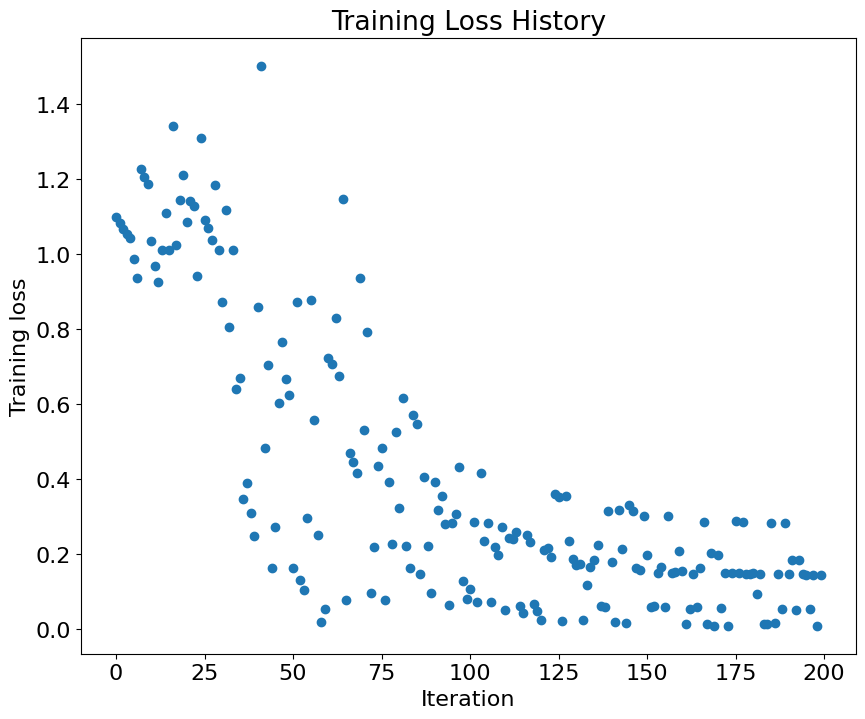

In [17]:
import utils
from utils import get_toy_data
from two_layer_net import nn_forward_backward, nn_train, nn_predict

utils.reset_seed(RANDOM_STATE)
toy_X, toy_y, params = get_toy_data(dtype=dtype,device=device)
    
# TODO: Implement the nn_train function.
# You may need to check nn_predict function (the "pred_func") as well.
p15_stats = nn_train(params, nn_forward_backward, nn_predict, toy_X, toy_y, toy_X, toy_y,
                 learning_rate=1e-1, reg=1e-6,
                 num_iters=200, batch_size=2, verbose=False)

print('Final training loss: ', p15_stats['loss_history'][-1])

# plot the loss history
plt.plot(p15_stats['loss_history'], 'o')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.title('Training Loss History')
plt.show()

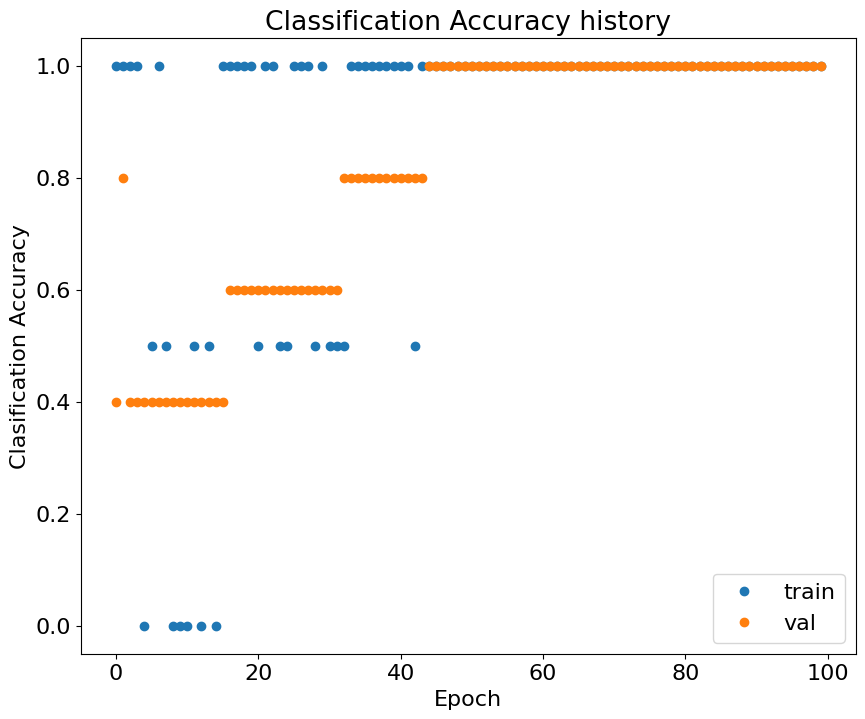

In [18]:
# Plot the loss function and train / validation accuracies
plt.plot(p15_stats['train_acc_history'], 'o', label='train')
plt.plot(p15_stats['val_acc_history'], 'o', label='val')
plt.title('Classification Accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification Accuracy')
plt.legend()
plt.show()

## Answer to Question 2:
I observed that as the number of iterations increased, the training loss would decrease and would do this in a non-linear manner. The loss curve shows a smooth curve, implying that the learning rate and batch size are well set. The training accuracy increased over time, approaching close to 100 percent accuracy by the end of the training. This shows that the model is effectively learning to classify the training data. Similarly, the validation accuracy also increased, closely following the training accuracy. Since, the training and validation accuracies were very close and both reached peaked values, there was no significant amount of overfitting since they both continued to improve.

# Part 2: Train a Neural Network Classifier for the CIFAR-10 Dataset
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to train a classifier on a real dataset - CIFAR-10.

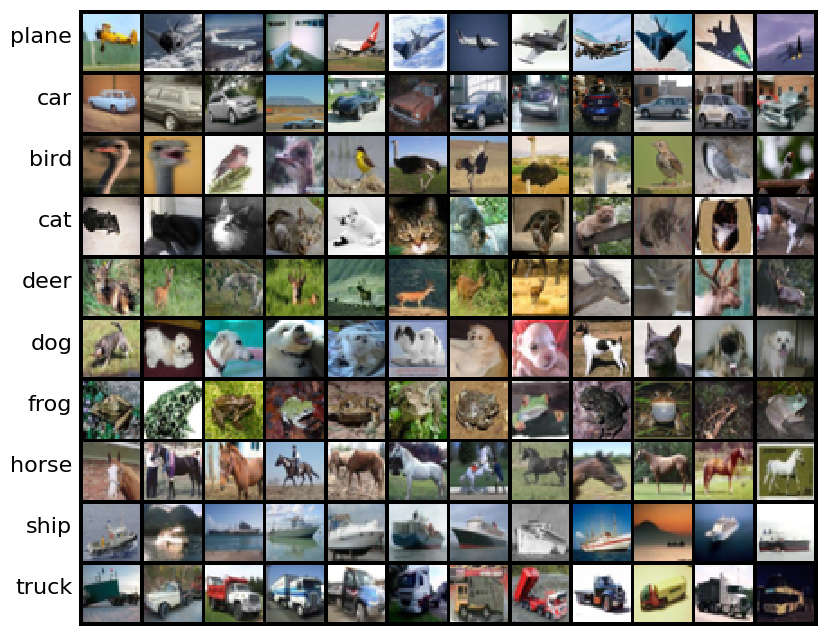

Train data shape:  torch.Size([40000, 3072])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3072])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 3072])
Test labels shape:  torch.Size([10000])


In [19]:
import utils

utils.reset_seed(RANDOM_STATE)

#This function will download and preprocess the CIFAR-10 dataset to your project directory.
data_dict = utils.preprocess_cifar10(dtype=dtype,device=device)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

## 2.0 - Explore Training NNs on the CIFAR-10 Dataset
Using your working implemention of the `TwoLayerNet` class you will investigate how the various hyperparameters affect model training and the ultimate performance of NN models. This part of the assigment is exploratory and will help you develop an intuition for how to identify issues in NN training, which can be used to inform your hyperparameter tuning strategy in Part 2.1.

The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are PyTorch tensors.


### 2.0.1 - Train an Initial Network on CIFAR-10
Using the `TwoLayerNet`, this will train an initial model via your SGD implementation from Part 1. In addition, we will adjust the learning rate with an **exponential learning rate schedule** as optimization proceed, i.e., after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [20]:
import utils
from two_layer_net import TwoLayerNet

input_size = 3 * 32 * 32
hidden_size = 36
num_classes = 10

# fix random seed before we generate a set of parameters
utils.reset_seed(RANDOM_STATE)
net = TwoLayerNet(input_size, hidden_size, num_classes, dtype=data_dict['X_train'].dtype, device=data_dict['X_train'].device)

# Train the network
stats = net.train(data_dict['X_train'], data_dict['y_train'],
                  data_dict['X_val'], data_dict['y_val'],
                  num_iters=500, batch_size=1000,
                  learning_rate=1e-2, learning_rate_decay=0.95,
                  reg=0.25, verbose=True)

# Predict on the validation set
y_val_pred = net.predict(data_dict['X_val'])
val_acc = 100.0 * (y_val_pred == data_dict['y_val']).double().mean().item()
print('Validation accuracy: %.2f%%' % val_acc)

iteration 0 / 500: loss 2.302864
iteration 100 / 500: loss 2.302711
iteration 200 / 500: loss 2.302587
iteration 300 / 500: loss 2.302557
iteration 400 / 500: loss 2.302490
Validation accuracy: 9.52%


### 2.0.2 - Investigate Training Performance
With the default parameters provided above, you should get a validation accuracy less than 10% on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

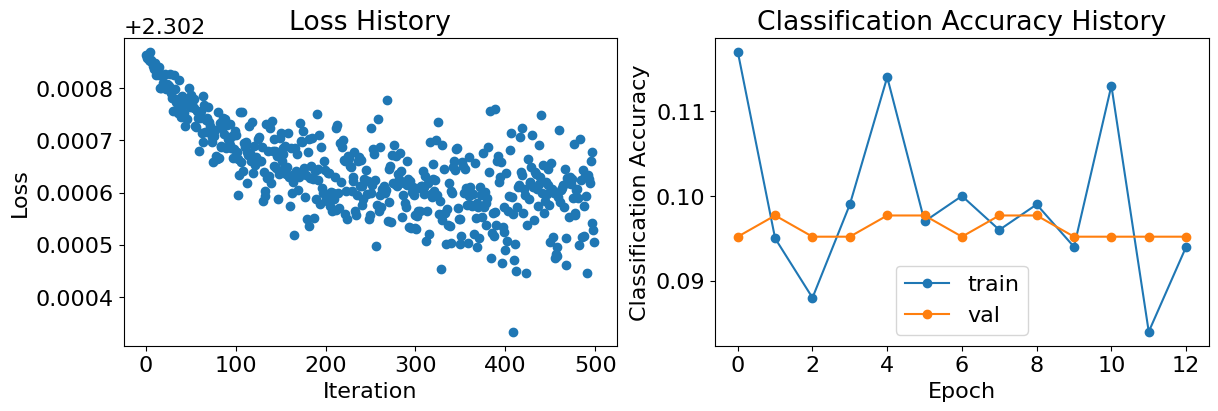

In [21]:
# Plot the loss function and train / validation accuracies
from utils import plot_stats

plot_stats(stats)

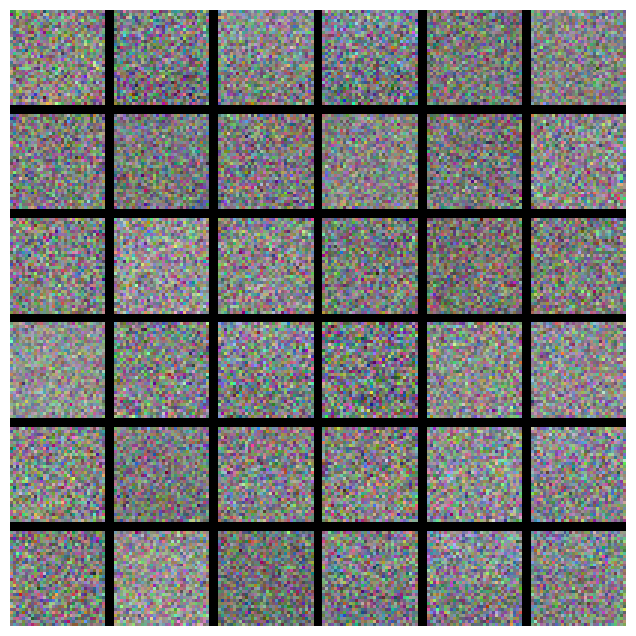

In [22]:
from utils import show_net_weights 

show_net_weights(net)

#### Interpreting the Results
Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

Additionally, the visualization of the weights above seems to be primarily white noise, though there are some linear patterns visible.

### 2.0.3 Investigating Capacity
The initial model has very similar performance on the training and validation sets. This suggests that the model is **underfitting** and that its performance might improve if we were to increase its **capacity**.

One way we can increase the capacity of a neural network model is to increase the size of its hidden layer. Here we investigate the effect of increasing the size of the hidden layer. The performance (as measured by validation set accuracy) should increase as the size of the hidden layer increases; however it may show diminishing returns for larger layer sizes.

train with hidden size: 2
train with hidden size: 8
train with hidden size: 32
train with hidden size: 128


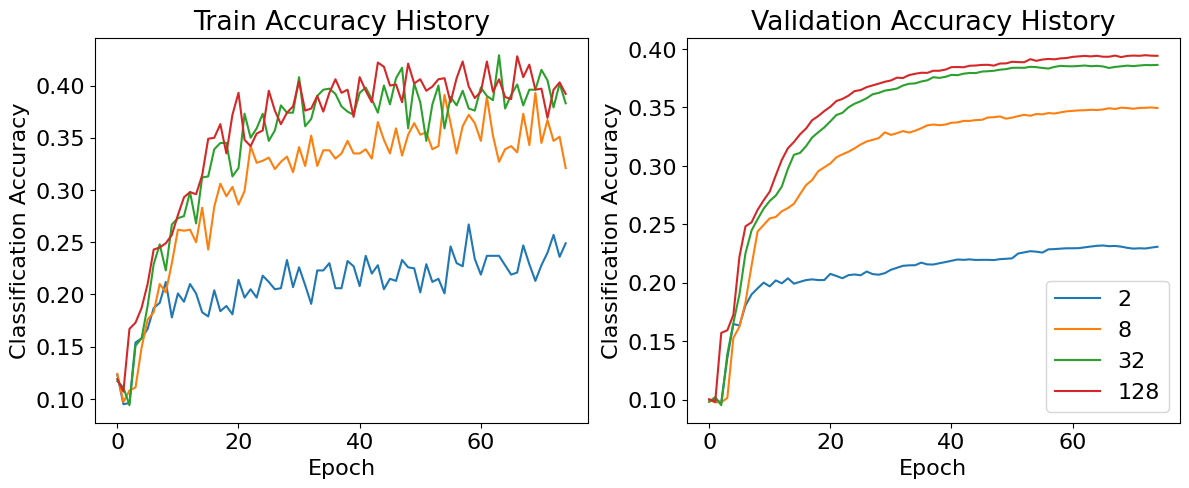

In [23]:
import utils
from utils import plot_acc_curves
from two_layer_net import TwoLayerNet

hidden_sizes = [2, 8, 32, 128] 
lr = 0.1
reg = 0.001

stat_dict = {}
for hs in hidden_sizes:
  print('train with hidden size: {}'.format(hs))
  # fix random seed before we generate a set of parameters
  utils.reset_seed(RANDOM_STATE)
  net = TwoLayerNet(3 * 32 * 32, hs, 10, device=data_dict['X_train'].device, dtype=data_dict['X_train'].dtype)
  stats = net.train(data_dict['X_train'], data_dict['y_train'], data_dict['X_val'], data_dict['y_val'],
            num_iters=3000, batch_size=1000,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg, verbose=False)
  stat_dict[hs] = stats

plot_acc_curves(stat_dict)

### 2.0.3 Investigating Regularization
Another possible explanation for the small gap in performance between the train and validation accuracies of our model is **regularization**. In particular, if the regularization coefficient was too high then the model may be unable to fit the training data.

We can investigate the phenomenon empirically by training a set of models with varying regularization strengths while fixing other hyperparameters.

You should see that setting the regularization strength too high will harm the validation set performance of the model:

train with regularization: 0
train with regularization: 1e-05
train with regularization: 0.001
train with regularization: 0.1


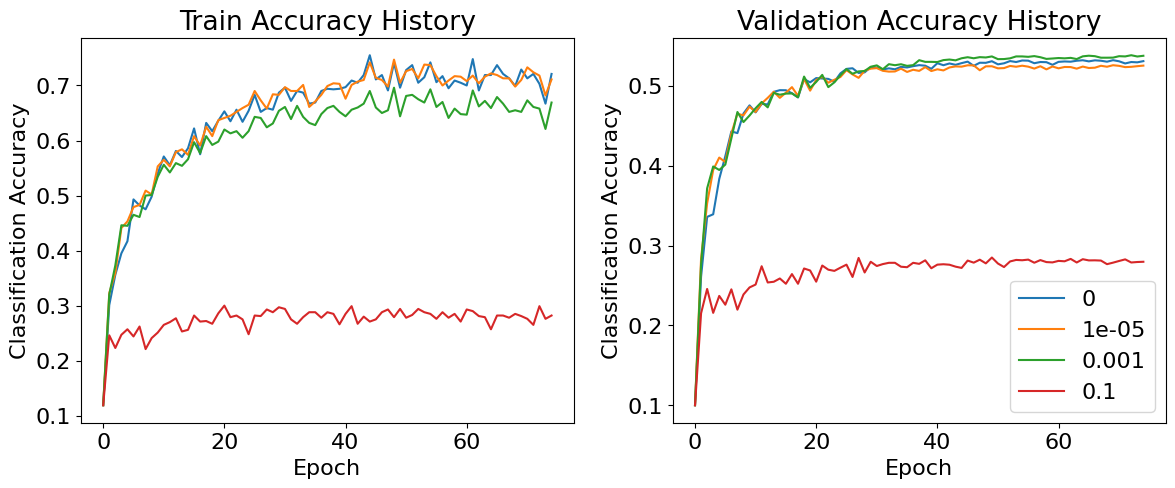

In [26]:
import utils
from utils import plot_acc_curves
from two_layer_net import TwoLayerNet

hs = 128
lr = 1.0
regs = [0, 1e-5, 1e-3, 1e-1]

stat_dict = {}
for reg in regs:
  print('train with regularization: {}'.format(reg))
  # fix random seed before we generate a set of parameters
  utils.reset_seed(RANDOM_STATE)
  net = TwoLayerNet(3 * 32 * 32, hs, 10, device=data_dict['X_train'].device, dtype=data_dict['X_train'].dtype)
  stats = net.train(data_dict['X_train'], data_dict['y_train'], data_dict['X_val'], data_dict['y_val'],
            num_iters=3000, batch_size=1000,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg, verbose=False)
  stat_dict[reg] = stats

plot_acc_curves(stat_dict)

### 2.0.4 Investigating Learning Rate
Last but not least, we also want to see the effect of **learning rate** with respect to the performance.

train with learning rate: 0.0001
train with learning rate: 0.01
train with learning rate: 1.0
train with learning rate: 100.0


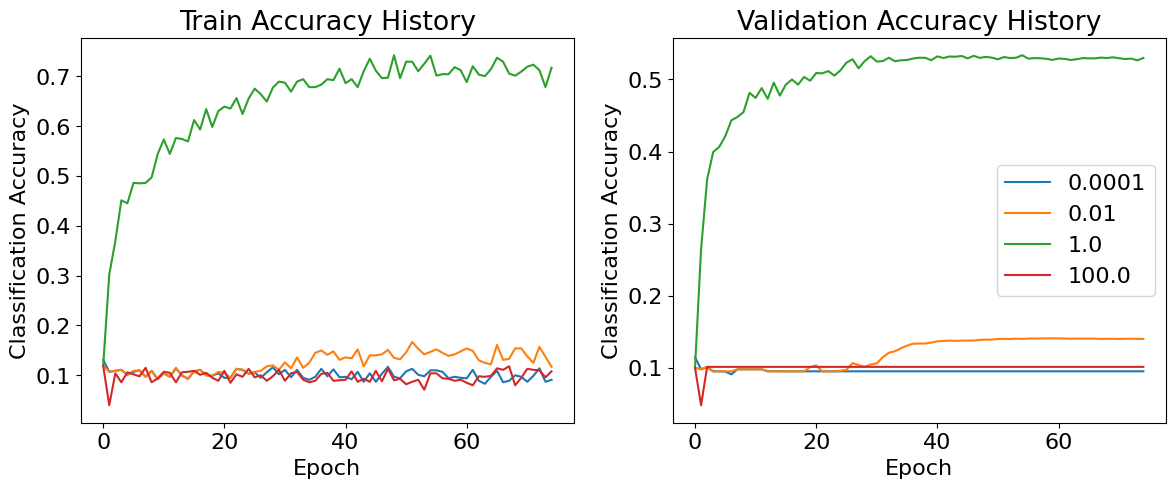

In [27]:
import utils
from utils import plot_acc_curves
from two_layer_net import TwoLayerNet

hs = 128
lrs = [1e-4, 1e-2, 1e0, 1e2]
reg = 1e-4

stat_dict = {}
for lr in lrs:
  print('train with learning rate: {}'.format(lr))
  # fix random seed before we generate a set of parameters
  utils.reset_seed(RANDOM_STATE)
  net = TwoLayerNet(3 * 32 * 32, hs, 10, device=data_dict['X_train'].device, dtype=data_dict['X_train'].dtype)
  stats = net.train(data_dict['X_train'], data_dict['y_train'], data_dict['X_val'], data_dict['y_val'],
            num_iters=3000, batch_size=1000,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg, verbose=False)
  stat_dict[lr] = stats

plot_acc_curves(stat_dict)

## 2.1 - Hyperparameter Tuning

1. You will now attempt to train a better NN on the CIFAR-10 dataset via hyperparameter tuning. Implement the functions `find_best_net` and `nn_get_search_params` in `two_layer_net.py`. Then run the code in the next few blocks to
   * return the best model and save it to disk,
   * plot loss and learning rates, and
   * compute validation set accuracy.
To get full credit for the assignment, you should achieve a classification accuracy above $50\%$ on the validation set.

2. Visualize the weights of your best-performing network using `utils.show_net_weights`. What visual patterns, if any, do you see in these weights, and how do they compare to the initial network you created in Part 2.0.1?

### Please Read!
**Tuning:** Tuning hyperparameters and developing an intuition for how they affect the final performance is a large part of using neural networks. Below, you should experiment with different combinations of the various **hyperparameters**, including *hidden layer size*, *learning rate*, *number of training epochs*, and *regularization strength*. You might also consider tuning the l*earning rate decay*, but you should be able to get good performance using the default value.

**Plots:** To guide your hyperparameter search, you might consider making auxiliary plots of training and validation performance as above, or plotting the results arising from different hyperparameter combinations. You should feel free to plot any auxiliary results you need in order to find a good network, but we won't require any particular plots from you.

**Approximate Results:** Results will vary due to the stochastic nature of training and your chosen hyperparameters. Our best model gets a validation set accuracy 56.44% -- did you beat us?

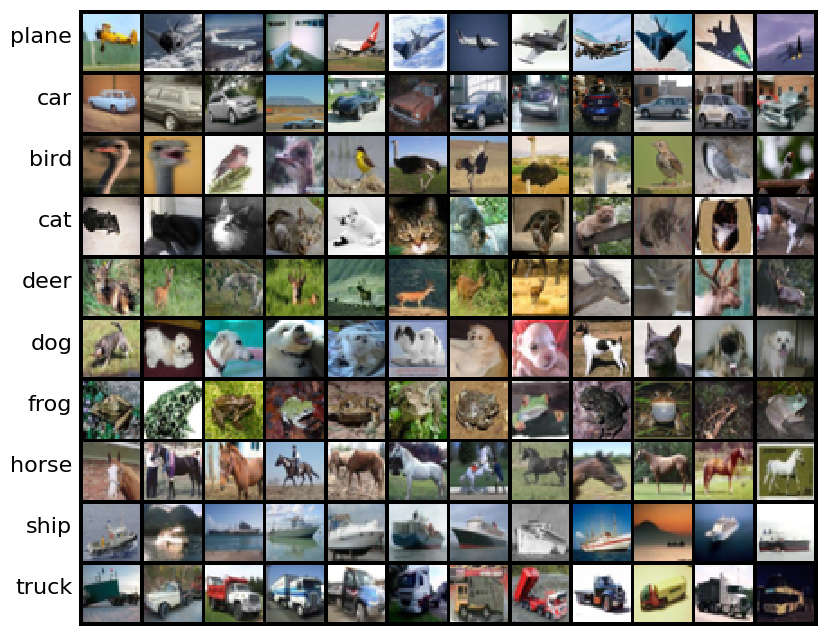

0.5422999858856201


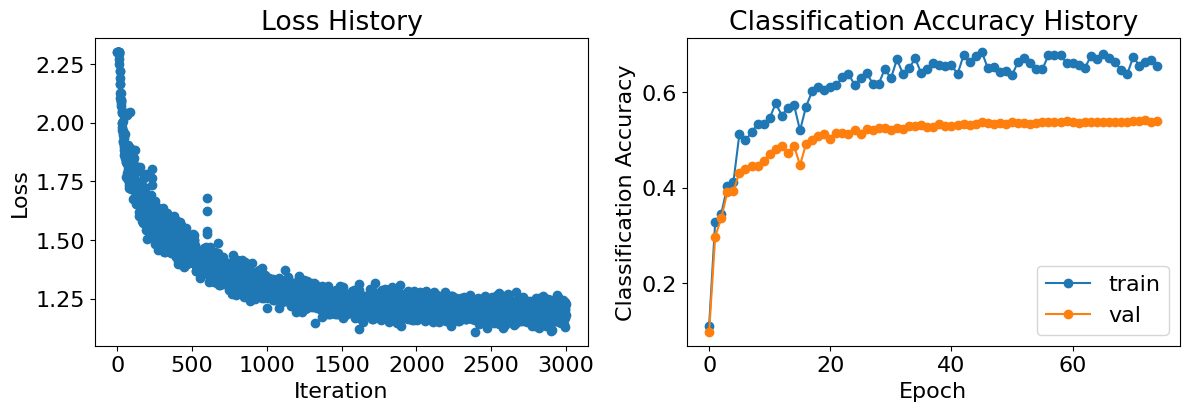

Saved in nn_best_model.pt


In [159]:
import os
import utils
from two_layer_net import TwoLayerNet, find_best_net, nn_get_search_params

# running this model on float64 may needs more time, so set it as float32
utils.reset_seed(RANDOM_STATE)
data_dict = utils.preprocess_cifar10(dtype=torch.float32, device=device)

# store the best model into this 
utils.reset_seed(RANDOM_STATE)
best_net, best_stat, best_val_acc = find_best_net(data_dict, nn_get_search_params)
print(best_val_acc)

plot_stats(best_stat)

# save the best model
best_net.save('nn_best_model.pt')

In [161]:
# Check the validation-set accuracy of your best model
y_val_preds = best_net.predict(data_dict['X_val'])
p21_val_acc = 100 * (y_val_preds == data_dict['y_val']).double().mean().item()
print('Best val-set accuracy: %.2f%%' % p21_val_acc)

Best val-set accuracy: 53.84%


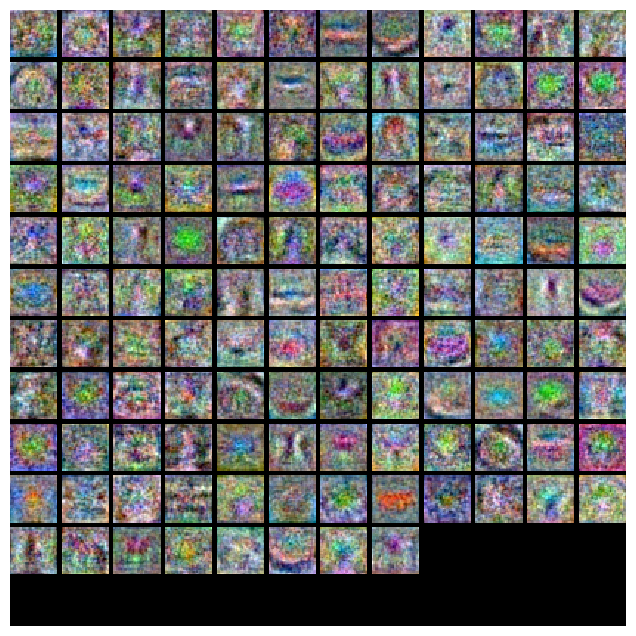

In [162]:
from utils import show_net_weights
# visualize the weights of the best network
show_net_weights(best_net)

## Answer to Question 2:
Compared to the previous visual depiction of the weights, this visual depiction of the weights of the best performing network is easier to interpret. In the previous depiction, it was quite hard to make out patterns, but here we can clearly see some features or patterns that are made out. This implies that in the best performing network, the model was able to learn meaningful representations of the input data which is consistent with its improved performance.

## 2.2 - Evaluate Model on the Test Set
When you are done experimenting, you should evaluate your final trained network on the test set. To get full credit for the assignment, you should achieve over $50\%$ classification accuracy on the test set.

(Our best model gets 56.03% test-set accuracy -- did you beat us?)

In [164]:
y_test_preds = best_net.predict(data_dict['X_test'])
p22_test_acc = 100 * (y_test_preds == data_dict['y_test']).double().mean().item()
print('Test accuracy: %.2f%%' % p22_test_acc)

Test accuracy: 53.53%
